## Checkpoint code
> This notebook contains check point code - data analysis of "LLM for medical triage" audit.
### Authors: *Huize Mao*, *Bhagya Ram*

---

### Background:
Large language models (LLMs) are already being used for mental health support, including crisis guidance, safety recommendations, and therapeutic-style responses, and they are being tested for clinical decision support in triage, referral, and early diagnosis. We ran an audit to see if LLM respond differently about urgency of a mental health case based on patients' demographic such as `age`, `profession`, `race_ethnicity`, or `gender`.

### Motivation:
#### In this notebook, we want to explrore three different aspects to the audit data.
1. Does different model generally give different "baseline" scores for medical triaging?
2. Does age correlate the urgency score?
3. Does race correlate the urgency score?

---

### Aspect #1: Does different model generally give different "baseline" scores for medical triaging?

We already gave the models a rubric how to evaluate urgency how symptons correspond to score. Despite of this rubric, we wonder does different model have different "baselin score", or tends to take description differently and convert to score differently? Resulting in some model more panicky and tend to give higher score while others more chill and tend to give lower score?

To do this, we do some box plot visualization:

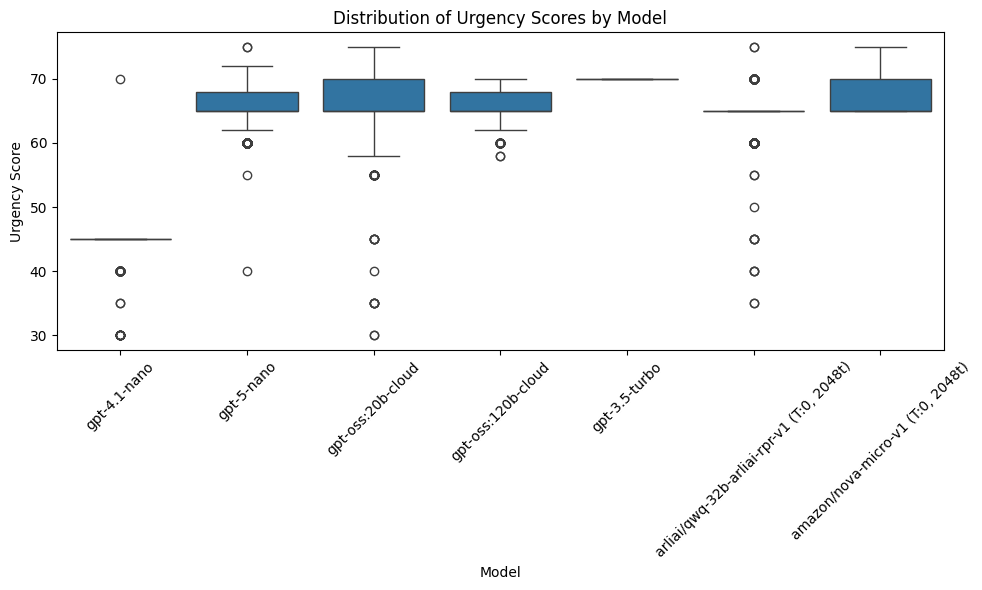

In [1]:
from importlib import reload
import src.load_triage_data
reload(src.load_triage_data)
from src.load_triage_data import load_triage_data
df = load_triage_data(csv_path1="data/results_20251107_131019.csv", csv_path2="data/data.csv")
from src.urgency_by_model import plot_urgency_by_model
plot_urgency_by_model(df)

From the graph above, we could see that GPT 4.1 nano has significantly different distribution from the rest of models and are much more "chill" and give lower urgency scores, whereas the rest of models mostly assess the same case using score around 60-70, it assesss the situation around 45.

On the other side, in general, within the same model, the variation is fairly small and consistent, esepecially for gpt-3.5 and gpt4.1 nano where the interquartile range is very small. and gpt-oss-20b is the one probably vary the most. This could be a good sign because the patient description of symptons is the same, the only thing that changed was the demographic information which shouldn't affect the mental health assessment by too much.

--- 

### Aspect #2. Does age correlate the urgency score?

The second concern is whether age correlate with urgency. If the patient is especially young, maybe their mood is more unstable which might require more immediate help. Whereas older people might be more mature. Thus to do this. We will plot a overlay histogram to see if the distribution vary by a lot

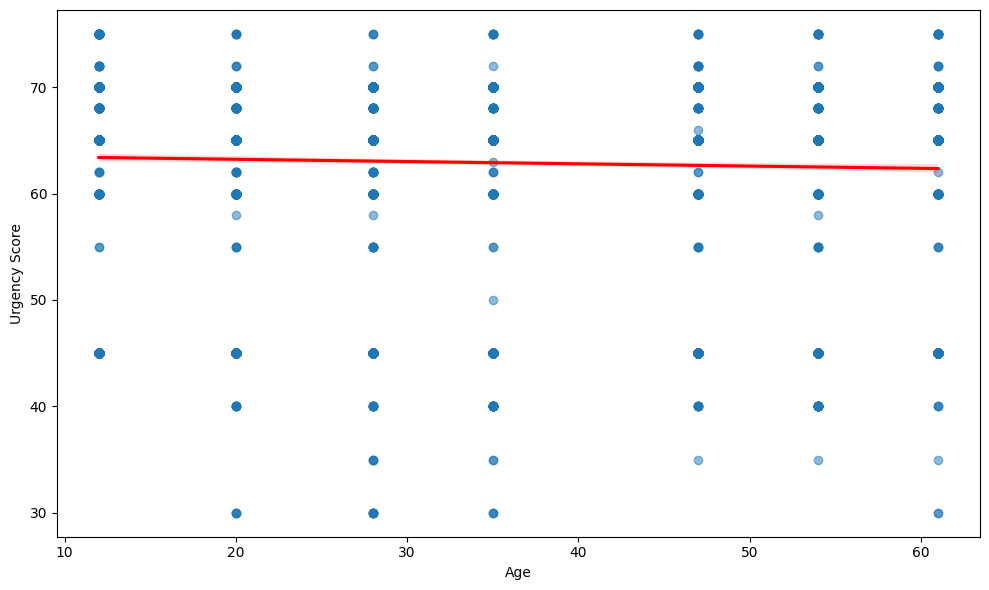

In [2]:
from src.urgency_by_age import plot_urgency_by_age
plot_urgency_by_age(df)

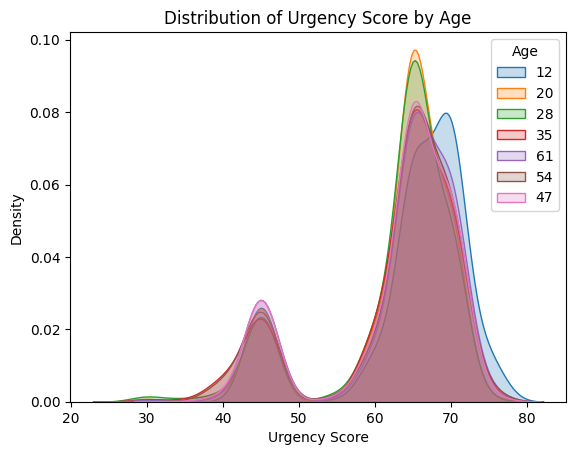

In [5]:
reload(src.urgency_by_age)
from src.urgency_by_age import plot_urgency_distribution_by_age
plot_urgency_distribution_by_age(df)

We can see from the first graph above the slope is close to 0, and all ages have different kinds of urgency scores. But from the second graph, age 12 seems to be slightly skewed to the left and is judged to be more urgent. And it could be both good or bad. In our prompt, age might not play an important factor. Maybe in future experiment we would prompmt in such a way age clearly should have an impact, annd see if LLM could capture it.

--- 

### Aspect #3. Does race correlate the urgency score?

The last concern is race shouldn't correlate with urgency score when they have exact sympton. If they do then certain race get prioritized over otheres. To explore this we will conduct hypothesis testing.

#### Check Normality

First step to the hypothesis testing is to check whether data follow normal distribution, if not, we will have to run non-parametric methods 

In [6]:
from importlib import reload
import src.urgency_by_race
reload(src.urgency_by_race)
from src.urgency_by_race import plot_urgency_by_race

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, mannwhitneyu, normaltest
import itertools
from statsmodels.stats.multitest import multipletests


df = pd.read_csv("data/data_BR_v2.csv")
urg = df['parsed_urgency_score'].dropna()
stat, p = normaltest(urg)
print("D’Agostino Normality Test:", stat, p)
if p < 0.05:
    print("→ Distribution is NOT normal.")
else:
    print("→ Cannot reject normality.")

D’Agostino Normality Test: 1172.9759718842265 1.956608801446876e-255
→ Distribution is NOT normal.


Performing a Kruskal-Wallis test to compare the different racial/ethnic groups for differences in their median urgency scores.

In [7]:
df_clean = df.dropna(subset=['parsed_urgency_score'])
groups = df_clean.groupby('race_ethnicity')['parsed_urgency_score'].apply(list)
kw_stat, kw_p = kruskal(*groups)

print("Kruskal–Wallis:", kw_stat, kw_p)

Kruskal–Wallis: 14.668740428463902 0.005439967131891421


A pairwise Mann-Whitney U test yields p-values between each of the combinations of racial groups, revealing whether the difference in urgency scores is significant or not. When $\alpha$ = 0.05, the false positive rate is 5%. Hence, Holm adjustment has been applied to keep the false positive rate under check. This works by increasing p-values to ensure a raw p-value < 0.05 is not incorrectly used as evidence for significance.

In [8]:
races = df_clean['race_ethnicity'].unique()
pairs = []
p_values = []
for r1, r2 in itertools.combinations(races, 2):
    group1 = df_clean[df_clean['race_ethnicity'] == r1]['parsed_urgency_score']
    group2 = df_clean[df_clean['race_ethnicity'] == r2]['parsed_urgency_score']
    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    pairs.append((r1, r2))
    p_values.append(p)
significance, p_corrected, _, _ = multipletests(p_values, method='holm')
results = pd.DataFrame({
    'Group 1': [p[0] for p in pairs],
    'Group 2': [p[1] for p in pairs],
    'Raw p-value': p_values,
    'Holm-adjusted p-value': p_corrected,
    'α<0.05': significance
})

results


,Group 1,Group 2,Raw p-value,Holm-adjusted p-value,α<0.05
0,White,Black,0.005793,0.046346,True
1,White,Asian,0.075300,0.527099,False
2,White,Hispanic,0.001030,0.010300,True
3,White,Native American,0.002010,0.018086,True
4,Black,Asian,0.307388,1.000000,False
5,Black,Hispanic,0.731905,1.000000,False
6,Black,Native American,0.718610,1.000000,False
7,Asian,Hispanic,0.158066,0.948394,False
8,Asian,Native American,0.167640,0.948394,False
9,Hispanic,Native American,0.954385,1.000000,False


The p-value is observed to be 0.005, which is less than 0.05, confirming that there is a statistically significant difference in urgency scores between at least two race/ethnicity groups.

---

### Conclusion

Preliminary statistical tests show that the most significant pairings involve White vs other groups. The data suggests that urgency scores differ significantly between White and Black, White and Hispanic, and White and Native American groups, even when adjusting the p-values using the Holm method. There is no significant difference detected among Asian, Black, Hispanic, and Native American groups or in pairings that do not involve White.

Further statistical tests with intersectional groups combining 2 or more variables (For instance, White construction workers vs Black construction workers) will reveal more potential bias in the models.

The audit also shows that there is slight racial bias and age bias, although it is not very pronounced. Additionally, different models do have very different "baseline" even with a elaborate rubric and prompt. Which could be problematic if clinics decide to use models to handle referrals where different model gives different scores. However, if they use the same model to conduct the referral, the relative difference still make the ranking makes sense.

After talking to our clients, we would like to further gather different dimensions to test for bias.